# 🌞 Parte 00: Preparación de Datos RSDS para Bias Correction

Este notebook implementa la **Parte 00** del pipeline de bias correction de RSDS (radiación solar) usando Quantile Mapping contra observaciones GHI del Valle de Aconcagua.

## Objetivos:
1. Cargar y explorar datos observacionales (GHI de solar.minenergia.cl)
2. Cargar y explorar datos CMIP6 ACCESS-CM2 historical (RSDS)
3. Normalizar coordenadas y calendarios
4. Realizar regridding a la grilla observacional
5. Alinear temporalmente los datasets
6. Aplicar filtros de calidad de datos
7. Preparar chunking para xclim.sdba
8. Validar preparación antes del entrenamiento QM

**Región**: Valle de Aconcagua, Chile (lat: -33.23° a -32.28°, lon: -71.88° a -70.03°)  
**Período de calibración**: 2004-01-01 a 2014-12-31 (~11 años, 132 meses)

## 1️⃣ Imports y Configuración

In [1]:
# Imports principales
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import glob
import json
from datetime import datetime
import warnings

# Dask para procesamiento paralelo
import dask
from dask.diagnostics import ProgressBar

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración de warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuración de Dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📦 xarray version: {xr.__version__}")
print(f"📦 pandas version: {pd.__version__}")
print(f"📦 numpy version: {np.__version__}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-10-19 00:35:43
📦 xarray version: 2025.1.2
📦 pandas version: 2.3.3
📦 numpy version: 2.3.3


## 2️⃣ Definición de Rutas y Parámetros

In [2]:
# Rutas base del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
DATA_DIR = BASE_DIR / 'data'
SCRIPTS_DIR = BASE_DIR / 'scripts' / 'copernicus' / 'rsds'

# Rutas de datos observacionales
OBS_ZARR = DATA_DIR / 'solar' / 'solar_diario_grilla.zarr'

# Rutas de datos CMIP6
CMIP6_RSDS_DIR = DATA_DIR / 'cmip6' / 'rsds'
HIST_FILE = CMIP6_RSDS_DIR / 'historical' / 'rsds_Amon_access_cm2_historical_r1i1p1f1_gn_185001-201412.nc'

# Rutas de salida
OUTPUT_DIR = SCRIPTS_DIR / 'output'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Parámetros de calibración
CALIB_START = '2004-01-01'
CALIB_END = '2014-12-31'

# Región de estudio (Valle de Aconcagua)
BBOX = {
    'lat_min': -33.23,
    'lat_max': -32.28,
    'lon_min': -71.88,
    'lon_max': -70.03
}

# Parámetros de calidad de datos
MIN_MONTHS_TOTAL = 60  # Mínimo de meses válidos en total
MIN_PER_MONTH = 6      # Mínimo de observaciones por mes del año

# Parámetros de chunking
MAX_SPATIAL_CHUNK = 50  # Tamaño máximo de chunk espacial

# Verificar existencia de archivos
print("🔍 Verificando existencia de archivos...")
print(f"   Obs GHI zarr: {'✅' if OBS_ZARR.exists() else '❌'} {OBS_ZARR}")
print(f"   CMIP6 historical: {'✅' if HIST_FILE.exists() else '❌'} {HIST_FILE}")

print(f"\n📍 Región: Valle de Aconcagua")
print(f"   Latitud: {BBOX['lat_min']}° a {BBOX['lat_max']}°")
print(f"   Longitud: {BBOX['lon_min']}° a {BBOX['lon_max']}°")
print(f"\n📅 Período de calibración: {CALIB_START} a {CALIB_END}")

🔍 Verificando existencia de archivos...
   Obs GHI zarr: ✅ /home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr
   CMIP6 historical: ✅ /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/historical/rsds_Amon_access_cm2_historical_r1i1p1f1_gn_185001-201412.nc

📍 Región: Valle de Aconcagua
   Latitud: -33.23° a -32.28°
   Longitud: -71.88° a -70.03°

📅 Período de calibración: 2004-01-01 a 2014-12-31


## 3️⃣ Cargar y Explorar Datos Observacionales (GHI)

In [3]:
# Cargar datos observacionales GHI
print("📂 Cargando datos observacionales GHI...")
obs_raw = xr.open_zarr(OBS_ZARR)

print("\n📊 Estructura del dataset observacional:")
print(obs_raw)

print("\n🔍 Información detallada:")
print(f"   Variables: {list(obs_raw.data_vars)}")
print(f"   Dimensiones: {dict(obs_raw.dims)}")
print(f"   Coordenadas: {list(obs_raw.coords)}")

# Extraer variable GHI
ghi_daily = obs_raw['ghi']

print(f"\n📏 Dimensiones de GHI:")
print(f"   Temporal: {ghi_daily.sizes.get('date', ghi_daily.sizes.get('time', 'N/A'))} días")
print(f"   Latitud: {ghi_daily.sizes['lat']} puntos")
print(f"   Longitud: {ghi_daily.sizes['lon']} puntos")

# Rango temporal
time_dim = 'date' if 'date' in ghi_daily.dims else 'time'
print(f"\n📅 Período temporal:")
print(f"   Inicio: {ghi_daily[time_dim].values[0]}")
print(f"   Fin: {ghi_daily[time_dim].values[-1]}")
print(f"   Duración: ~{(pd.to_datetime(ghi_daily[time_dim].values[-1]) - pd.to_datetime(ghi_daily[time_dim].values[0])).days / 365:.1f} años")

# Rango espacial
print(f"\n🌍 Cobertura espacial:")
print(f"   Latitud: {float(ghi_daily.lat.min()):.4f}° a {float(ghi_daily.lat.max()):.4f}°")
print(f"   Longitud: {float(ghi_daily.lon.min()):.4f}° a {float(ghi_daily.lon.max()):.4f}°")

# Unidades y atributos
print(f"\n📋 Metadatos:")
print(f"   Unidades: {ghi_daily.attrs.get('units', 'N/A')}")
for key, val in ghi_daily.attrs.items():
    if key != 'units':
        print(f"   {key}: {val}")

# Estadísticas básicas
print(f"\n📈 Estadísticas (primeros 1000 pasos temporales para rapidez):")
sample = ghi_daily.isel({time_dim: slice(0, 1000)})
print(f"   Media: {float(sample.mean()):.2f} W/m²")
print(f"   Desv. Est.: {float(sample.std()):.2f} W/m²")
print(f"   Mínimo: {float(sample.min()):.2f} W/m²")
print(f"   Máximo: {float(sample.max()):.2f} W/m²")
print(f"   % NaN: {float(sample.isnull().mean() * 100):.2f}%")

📂 Cargando datos observacionales GHI...

📊 Estructura del dataset observacional:
<xarray.Dataset> Size: 76MB
Dimensions:  (date: 4748, lat: 20, lon: 20)
Coordinates:
  * date     (date) datetime64[ns] 38kB 2004-01-01 2004-01-02 ... 2016-12-30
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
Data variables:
    cloud    (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    temp     (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    vel      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    dni      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    ghi      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>

🔍 Información detallada:
   Variables: ['cloud', 'temp', 'vel', 'dni', 'ghi']
   Dimensiones: {'date': 4

## 4️⃣ Preparar Observaciones: Renombrar y Convertir a Mensual

In [4]:
print("🔄 Preparando datos observacionales...")

# Paso 1: Renombrar dimensión temporal a 'time'
if 'date' in ghi_daily.dims:
    print("   ✓ Renombrando 'date' → 'time'")
    ghi_daily = ghi_daily.rename({'date': 'time'})
else:
    print("   ✓ Dimensión temporal ya se llama 'time'")

# Paso 2: Convertir a mensual (promedio mensual)
print("   ✓ Convirtiendo de diario a mensual (promedio)...")
print(f"     Datos originales: {len(ghi_daily.time)} días")

obs_monthly = ghi_daily.resample(time='MS').mean(dim='time', skipna=True)

print(f"     Datos mensuales: {len(obs_monthly.time)} meses")
print(f"     Período: {pd.to_datetime(obs_monthly.time.values[0]).strftime('%Y-%m')} a {pd.to_datetime(obs_monthly.time.values[-1]).strftime('%Y-%m')}")

# Paso 3: Renombrar variable a 'rsds' para compatibilidad
print("   ✓ Renombrando variable 'ghi' → 'rsds'")
obs_monthly = obs_monthly.rename('rsds')

# Paso 4: Verificar unidades
if 'units' not in obs_monthly.attrs or obs_monthly.attrs['units'] == 'W/m²':
    obs_monthly.attrs['units'] = 'W m-2'
    print(f"   ✓ Unidades confirmadas: {obs_monthly.attrs['units']}")

# Paso 5: Añadir metadatos
obs_monthly.attrs['long_name'] = 'Surface Downwelling Shortwave Radiation (from GHI observations)'
obs_monthly.attrs['source'] = 'solar.minenergia.cl (monthly average from daily data)'
obs_monthly.attrs['temporal_resolution'] = 'monthly'
obs_monthly.attrs['original_frequency'] = 'daily'

print("\n✅ Datos observacionales preparados:")
print(obs_monthly)

# Validación rápida
print("\n🔍 Validación post-procesamiento:")
print(f"   Media mensual: {float(obs_monthly.mean()):.2f} W/m²")
print(f"   % NaN: {float(obs_monthly.isnull().mean() * 100):.2f}%")
print(f"   Total de meses: {len(obs_monthly.time)}")

🔄 Preparando datos observacionales...
   ✓ Renombrando 'date' → 'time'
   ✓ Convirtiendo de diario a mensual (promedio)...
     Datos originales: 4748 días
     Datos mensuales: 156 meses
     Período: 2004-01 a 2016-12
   ✓ Renombrando variable 'ghi' → 'rsds'
   ✓ Unidades confirmadas: W m-2

✅ Datos observacionales preparados:
<xarray.DataArray 'rsds' (time: 156, lat: 20, lon: 20)> Size: 499kB
dask.array<transpose, shape=(156, 20, 20), dtype=float64, chunksize=(39, 5, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2004-01-01 2004-02-01 ... 2016-12-01
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
Attributes:
    units:                W m-2
    long_name:            Surface Downwelling Shortwave Radiation (from GHI o...
    source:               solar.minenergia.cl (monthly average from daily data)
    temporal_resolution:  monthly
    origina

## 5️⃣ Seleccionar Período de Calibración (Observaciones)

In [5]:
print(f"📅 Seleccionando período de calibración: {CALIB_START} a {CALIB_END}")

# Seleccionar período
obs_calib = obs_monthly.sel(time=slice(CALIB_START, CALIB_END))

print(f"\n✅ Período de calibración seleccionado:")
print(f"   Inicio: {pd.to_datetime(obs_calib.time.values[0]).strftime('%Y-%m-%d')}")
print(f"   Fin: {pd.to_datetime(obs_calib.time.values[-1]).strftime('%Y-%m-%d')}")
print(f"   Total meses: {len(obs_calib.time)}")
print(f"   Años completos: {len(obs_calib.time) / 12:.1f}")

# Verificar que hay datos
if len(obs_calib.time) == 0:
    print("\n⚠️ ADVERTENCIA: No hay datos en el período seleccionado")
else:
    print(f"\n📊 Estadísticas del período de calibración:")
    print(f"   Media: {float(obs_calib.mean()):.2f} W/m²")
    print(f"   Mín: {float(obs_calib.min()):.2f} W/m²")
    print(f"   Máx: {float(obs_calib.max()):.2f} W/m²")
    print(f"   % NaN: {float(obs_calib.isnull().mean() * 100):.2f}%")

📅 Seleccionando período de calibración: 2004-01-01 a 2014-12-31

✅ Período de calibración seleccionado:
   Inicio: 2004-01-01
   Fin: 2014-12-01
   Total meses: 132
   Años completos: 11.0

📊 Estadísticas del período de calibración:
   Media: 225.47 W/m²
   Mín: 17.66 W/m²
   Máx: 429.42 W/m²
   % NaN: 17.50%


## 6️⃣ Cargar y Explorar CMIP6 Historical

In [6]:
print("📂 Cargando CMIP6 ACCESS-CM2 historical...")

# Cargar archivo
hist_raw = xr.open_dataset(HIST_FILE)

print("\n📊 Estructura del dataset CMIP6:")
print(hist_raw)

print("\n🔍 Información detallada:")
print(f"   Variables: {list(hist_raw.data_vars)}")
print(f"   Dimensiones: {dict(hist_raw.dims)}")
print(f"   Coordenadas: {list(hist_raw.coords)}")

# Extraer variable RSDS
rsds_hist = hist_raw['rsds']

print(f"\n📏 Dimensiones de RSDS historical:")
print(f"   Temporal: {rsds_hist.sizes['time']} meses")
print(f"   Latitud: {rsds_hist.sizes.get('lat', rsds_hist.sizes.get('latitude', 'N/A'))} puntos")
print(f"   Longitud: {rsds_hist.sizes.get('lon', rsds_hist.sizes.get('longitude', 'N/A'))} puntos")

# Período temporal
print(f"\n📅 Período temporal:")
print(f"   Inicio: {pd.to_datetime(rsds_hist.time.values[0])}")
print(f"   Fin: {pd.to_datetime(rsds_hist.time.values[-1])}")
print(f"   Duración: {len(rsds_hist.time) / 12:.1f} años")

# Información del calendario
calendar = rsds_hist.time.encoding.get('calendar', rsds_hist.time.attrs.get('calendar', 'N/A'))
print(f"\n📆 Calendario: {calendar}")

# Coordenadas espaciales
lat_name = 'lat' if 'lat' in rsds_hist.dims else 'latitude'
lon_name = 'lon' if 'lon' in rsds_hist.dims else 'longitude'

print(f"\n🌍 Cobertura espacial (global):")
print(f"   Latitud: {float(rsds_hist[lat_name].min()):.2f}° a {float(rsds_hist[lat_name].max()):.2f}°")
print(f"   Longitud: {float(rsds_hist[lon_name].min()):.2f}° a {float(rsds_hist[lon_name].max()):.2f}°")
print(f"   Rango lon: [0, 360] format" if float(rsds_hist[lon_name].max()) > 180 else "   Rango lon: [-180, 180] format")

# Resolución aproximada
lat_res = float(np.diff(rsds_hist[lat_name].values).mean())
lon_res = float(np.diff(rsds_hist[lon_name].values).mean())
print(f"\n📐 Resolución espacial (aprox):")
print(f"   Latitud: {abs(lat_res):.3f}°")
print(f"   Longitud: {abs(lon_res):.3f}°")

# Unidades
print(f"\n📋 Metadatos:")
print(f"   Unidades: {rsds_hist.attrs.get('units', 'N/A')}")
print(f"   Nombre largo: {rsds_hist.attrs.get('long_name', 'N/A')}")

# Estadísticas básicas (muestra global)
print(f"\n📈 Estadísticas globales (muestra temporal):")
sample = rsds_hist.isel(time=slice(-120, -1))  # Últimos 10 años
print(f"   Media: {float(sample.mean()):.2f} W/m²")
print(f"   Mín: {float(sample.min()):.2f} W/m²")
print(f"   Máx: {float(sample.max()):.2f} W/m²")

📂 Cargando CMIP6 ACCESS-CM2 historical...

📊 Estructura del dataset CMIP6:
<xarray.Dataset> Size: 219MB
Dimensions:    (time: 1980, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 32kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    rsds       (time, lat, lon) float32 219MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T09:24:51Z
    ...                     ...
    variable_id:            rsds
    variant_label:          r1i1p1f1

## 7️⃣ Normalizar Coordenadas CMIP6

In [7]:
print("🔄 Normalizando coordenadas CMIP6...")

hist = rsds_hist.copy()

# Paso 1: Renombrar coordenadas si es necesario
if 'latitude' in hist.dims:
    print("   ✓ Renombrando 'latitude' → 'lat'")
    hist = hist.rename({'latitude': 'lat'})
if 'longitude' in hist.dims:
    print("   ✓ Renombrando 'longitude' → 'lon'")
    hist = hist.rename({'longitude': 'lon'})

# Paso 2: Convertir longitud de [0, 360] a [-180, 180] si es necesario
if float(hist.lon.max()) > 180:
    print("   ✓ Convirtiendo longitud de [0, 360] a [-180, 180]")
    hist = hist.assign_coords(lon=(((hist.lon + 180) % 360) - 180))
    hist = hist.sortby('lon')
else:
    print("   ✓ Longitud ya está en formato [-180, 180]")

# Paso 3: Ordenar latitud ascendente
if hist.lat.values[0] > hist.lat.values[-1]:
    print("   ✓ Ordenando latitud en orden ascendente")
    hist = hist.sortby('lat')
else:
    print("   ✓ Latitud ya está en orden ascendente")

# Paso 4: Verificar calendario
calendar_type = hist.time.encoding.get('calendar', hist.time.attrs.get('calendar', 'standard'))
print(f"\n📆 Información de calendario:")
print(f"   Tipo: {calendar_type}")
if calendar_type in ['360_day', 'noleap', '365_day']:
    print(f"   ⚠️ ADVERTENCIA: Calendario no estándar detectado ({calendar_type})")
    print(f"      → Se manejará en el paso de alineación temporal")
else:
    print(f"   ✓ Calendario estándar")

print("\n✅ Coordenadas normalizadas:")
print(f"   Latitud: {float(hist.lat.min()):.2f}° a {float(hist.lat.max()):.2f}° ({len(hist.lat)} puntos)")
print(f"   Longitud: {float(hist.lon.min()):.2f}° a {float(hist.lon.max()):.2f}° ({len(hist.lon)} puntos)")
print(f"   Tiempo: {len(hist.time)} meses")

🔄 Normalizando coordenadas CMIP6...
   ✓ Convirtiendo longitud de [0, 360] a [-180, 180]
   ✓ Latitud ya está en orden ascendente

📆 Información de calendario:
   Tipo: proleptic_gregorian
   ✓ Calendario estándar

✅ Coordenadas normalizadas:
   Latitud: -89.38° a 89.38° (144 puntos)
   Longitud: -179.06° a 179.06° (192 puntos)
   Tiempo: 1980 meses


## 8️⃣ Seleccionar Período de Calibración (CMIP6)

In [8]:
print(f"📅 Seleccionando período de calibración CMIP6: {CALIB_START} a {CALIB_END}")

# Seleccionar período
hist_calib = hist.sel(time=slice(CALIB_START, CALIB_END))

print(f"\n✅ Período de calibración CMIP6:")
print(f"   Inicio: {pd.to_datetime(hist_calib.time.values[0])}")
print(f"   Fin: {pd.to_datetime(hist_calib.time.values[-1])}")
print(f"   Total meses: {len(hist_calib.time)}")
print(f"   Años: {len(hist_calib.time) / 12:.1f}")

# Verificar traslape con observaciones
print(f"\n🔍 Verificación de traslape temporal:")
print(f"   Obs meses: {len(obs_calib.time)}")
print(f"   CMIP6 meses: {len(hist_calib.time)}")

if len(hist_calib.time) == 0:
    print("\n⚠️ ADVERTENCIA: No hay datos CMIP6 en el período seleccionado")
else:
    print(f"\n📊 Estadísticas CMIP6 (período calibración, global):")
    print(f"   Media: {float(hist_calib.mean()):.2f} W/m²")
    print(f"   Mín: {float(hist_calib.min()):.2f} W/m²")
    print(f"   Máx: {float(hist_calib.max()):.2f} W/m²")

📅 Seleccionando período de calibración CMIP6: 2004-01-01 a 2014-12-31

✅ Período de calibración CMIP6:
   Inicio: 2004-01-16 12:00:00
   Fin: 2014-12-16 12:00:00
   Total meses: 132
   Años: 11.0

🔍 Verificación de traslape temporal:
   Obs meses: 132
   CMIP6 meses: 132

📊 Estadísticas CMIP6 (período calibración, global):
   Media: 166.44 W/m²
   Mín: 0.00 W/m²
   Máx: 462.21 W/m²


## 9️⃣ Regridding: CMIP6 → Grilla Observacional

In [9]:
print("🌐 Realizando regridding de CMIP6 a grilla observacional...")
print(f"\n📍 Grilla objetivo (observaciones):")
print(f"   Latitud: {len(obs_calib.lat)} puntos ({float(obs_calib.lat.min()):.4f}° a {float(obs_calib.lat.max()):.4f}°)")
print(f"   Longitud: {len(obs_calib.lon)} puntos ({float(obs_calib.lon.min()):.4f}° a {float(obs_calib.lon.max()):.4f}°)")

print(f"\n📍 Grilla origen (CMIP6 calibración):")
print(f"   Latitud: {len(hist_calib.lat)} puntos")
print(f"   Longitud: {len(hist_calib.lon)} puntos")

# Interpolación bilineal
print("\n   ⏳ Interpolando (método: bilineal)...")
hist_regrid = hist_calib.interp(
    lat=obs_calib.lat,
    lon=obs_calib.lon,
    method='linear'
)

print("   ✅ Regridding completado")

# Verificar dimensiones
print(f"\n🔍 Verificación post-regridding:")
print(f"   Dimensiones: {dict(hist_regrid.sizes)}")
print(f"   Forma: time={len(hist_regrid.time)}, lat={len(hist_regrid.lat)}, lon={len(hist_regrid.lon)}")

# Verificar que las coordenadas son idénticas
coords_match = (
    np.allclose(hist_regrid.lat.values, obs_calib.lat.values, rtol=1e-5) and
    np.allclose(hist_regrid.lon.values, obs_calib.lon.values, rtol=1e-5)
)

if coords_match:
    print("   ✅ Coordenadas espaciales IDÉNTICAS entre obs y CMIP6")
else:
    print("   ⚠️ ADVERTENCIA: Coordenadas espaciales NO son idénticas")
    print(f"      Lat diff max: {np.abs(hist_regrid.lat.values - obs_calib.lat.values).max()}")
    print(f"      Lon diff max: {np.abs(hist_regrid.lon.values - obs_calib.lon.values).max()}")

# Estadísticas post-regridding
print(f"\n📊 Estadísticas CMIP6 regridded:")
print(f"   Media: {float(hist_regrid.mean()):.2f} W/m²")
print(f"   Mín: {float(hist_regrid.min()):.2f} W/m²")
print(f"   Máx: {float(hist_regrid.max()):.2f} W/m²")
print(f"   % NaN: {float(hist_regrid.isnull().mean() * 100):.2f}%")

🌐 Realizando regridding de CMIP6 a grilla observacional...

📍 Grilla objetivo (observaciones):
   Latitud: 20 puntos (-33.2250° a -32.2750°)
   Longitud: 20 puntos (-71.8750° a -70.0250°)

📍 Grilla origen (CMIP6 calibración):
   Latitud: 144 puntos
   Longitud: 192 puntos

   ⏳ Interpolando (método: bilineal)...
   ✅ Regridding completado

🔍 Verificación post-regridding:
   Dimensiones: {'time': 132, 'lat': 20, 'lon': 20}
   Forma: time=132, lat=20, lon=20
   ✅ Coordenadas espaciales IDÉNTICAS entre obs y CMIP6

📊 Estadísticas CMIP6 regridded:
   Media: 243.07 W/m²
   Mín: 75.16 W/m²
   Máx: 396.46 W/m²
   % NaN: 0.00%


## 🔟 Alineación Temporal y Manejo de Calendarios

In [11]:
def harmonize_monthly_time(ref, hist):
    """
    Alinea tiempo mensual usando solo año-mes, ignorando días y calendarios.
    
    Parameters:
    -----------
    ref : xr.DataArray
        Dataset de referencia (observaciones)
    hist : xr.DataArray
        Dataset histórico (CMIP6)
    
    Returns:
    --------
    tuple : (ref_aligned, hist_aligned)
        Datasets alineados temporalmente
    """
    print("🕐 Alineando coordenadas temporales...")
    
    # Extraer año-mes de ambos datasets
    ref_ym = [(int(y), int(m)) for y, m in zip(
        ref.time.dt.year.values, 
        ref.time.dt.month.values
    )]
    hist_ym = [(int(y), int(m)) for y, m in zip(
        hist.time.dt.year.values, 
        hist.time.dt.month.values
    )]
    
    print(f"   Ref año-mes: {len(ref_ym)} puntos ({ref_ym[0]} a {ref_ym[-1]})")
    print(f"   Hist año-mes: {len(hist_ym)} puntos ({hist_ym[0]} a {hist_ym[-1]})")
    
    # Encontrar intersección
    common = sorted(set(ref_ym) & set(hist_ym))
    print(f"   Intersección: {len(common)} meses comunes")
    
    if len(common) == 0:
        raise ValueError("❌ No hay traslape temporal entre observaciones y CMIP6")
    
    # Seleccionar índices correspondientes
    ref_idx = [i for i, ym in enumerate(ref_ym) if ym in common]
    hist_idx = [i for i, ym in enumerate(hist_ym) if ym in common]
    
    print(f"   Índices ref: {len(ref_idx)} seleccionados")
    print(f"   Índices hist: {len(hist_idx)} seleccionados")
    
    # Crear subsets alineados
    ref_aligned = ref.isel(time=ref_idx)
    hist_aligned = hist.isel(time=hist_idx)
    
    # Reasignar índice temporal común (datetime64)
    new_time = pd.to_datetime([f"{y:04d}-{m:02d}-01" for y, m in common])
    ref_aligned = ref_aligned.assign_coords(time=('time', new_time))
    hist_aligned = hist_aligned.assign_coords(time=('time', new_time))
    
    print(f"\n   ✅ Alineación completada:")
    print(f"      Período: {new_time[0].strftime('%Y-%m')} a {new_time[-1].strftime('%Y-%m')}")
    print(f"      Total: {len(new_time)} meses ({len(new_time)/12:.1f} años)")
    
    return ref_aligned, hist_aligned

# Aplicar alineación
obs_aligned, hist_aligned = harmonize_monthly_time(obs_calib, hist_regrid)

print("\n🔍 Verificación de alineación:")
print(f"   Obs: {len(obs_aligned.time)} meses")
print(f"   CMIP6: {len(hist_aligned.time)} meses")
print(f"   Tiempo idéntico: {np.array_equal(obs_aligned.time.values, hist_aligned.time.values)}")

🕐 Alineando coordenadas temporales...
   Ref año-mes: 132 puntos ((2004, 1) a (2014, 12))
   Hist año-mes: 132 puntos ((2004, 1) a (2014, 12))
   Intersección: 132 meses comunes
   Índices ref: 132 seleccionados
   Índices hist: 132 seleccionados

   ✅ Alineación completada:
      Período: 2004-01 a 2014-12
      Total: 132 meses (11.0 años)

🔍 Verificación de alineación:
   Obs: 132 meses
   CMIP6: 132 meses
   Tiempo idéntico: True


## 1️⃣1️⃣ Enmascarar Celdas con Datos Insuficientes

In [12]:
def mask_insufficient_data(ref, hist, min_months=60, min_per_month=6):
    """
    Enmascara celdas con datos insuficientes.
    
    Parameters:
    -----------
    ref : xr.DataArray
        Dataset de referencia (observaciones)
    hist : xr.DataArray
        Dataset histórico (CMIP6)
    min_months : int
        Mínimo de meses válidos en total
    min_per_month : int
        Mínimo de observaciones por cada mes del año (1-12)
    
    Returns:
    --------
    tuple : (ref_masked, hist_masked)
        Datasets con máscaras de calidad aplicadas
    """
    print(f"🎯 Aplicando filtros de calidad de datos...")
    print(f"   Criterio 1: Mínimo {min_months} meses válidos en total")
    print(f"   Criterio 2: Mínimo {min_per_month} observaciones por mes del año")
    
    # Criterio 1: Total de meses válidos
    ref_valid_total = ref.notnull().sum('time')
    hist_valid_total = hist.notnull().sum('time')
    ok_total = (ref_valid_total >= min_months) & (hist_valid_total >= min_months)
    
    print(f"\n   📊 Criterio 1 (total de meses válidos):")
    print(f"      Celdas OK: {int(ok_total.sum())} de {ok_total.size} ({float(ok_total.mean()*100):.1f}%)")
    
    # Criterio 2: Mínimo por cada mes del año (1-12)
    ref_by_month = ref.notnull().groupby('time.month').sum('time')
    hist_by_month = hist.notnull().groupby('time.month').sum('time')
    
    ok_monthly_ref = (ref_by_month >= min_per_month).all('month')
    ok_monthly_hist = (hist_by_month >= min_per_month).all('month')
    ok_monthly = ok_monthly_ref & ok_monthly_hist
    
    print(f"\n   📊 Criterio 2 (por mes del año):")
    print(f"      Celdas OK: {int(ok_monthly.sum())} de {ok_monthly.size} ({float(ok_monthly.mean()*100):.1f}%)")
    
    # Combinar criterios
    mask = ok_total & ok_monthly
    
    print(f"\n   ✅ Máscara final combinada:")
    print(f"      Celdas válidas: {int(mask.sum())} de {mask.size} ({float(mask.mean()*100):.1f}%)")
    print(f"      Celdas enmascaradas: {int((~mask).sum())} ({float((~mask).mean()*100):.1f}%)")
    
    # Aplicar máscara
    ref_masked = ref.where(mask)
    hist_masked = hist.where(mask)
    
    # Estadísticas post-máscara
    print(f"\n   📈 Estadísticas post-máscara (ref):")
    print(f"      % NaN antes: {float(ref.isnull().mean() * 100):.2f}%")
    print(f"      % NaN después: {float(ref_masked.isnull().mean() * 100):.2f}%")
    
    print(f"\n   📈 Estadísticas post-máscara (hist):")
    print(f"      % NaN antes: {float(hist.isnull().mean() * 100):.2f}%")
    print(f"      % NaN después: {float(hist_masked.isnull().mean() * 100):.2f}%")
    
    return ref_masked, hist_masked

# Aplicar función
obs_masked, hist_masked = mask_insufficient_data(
    obs_aligned, 
    hist_aligned,
    min_months=MIN_MONTHS_TOTAL,
    min_per_month=MIN_PER_MONTH
)

print("\n✅ Enmascaramiento completado")

🎯 Aplicando filtros de calidad de datos...
   Criterio 1: Mínimo 60 meses válidos en total
   Criterio 2: Mínimo 6 observaciones por mes del año

   📊 Criterio 1 (total de meses válidos):
      Celdas OK: 330 de 400 (82.5%)

   📊 Criterio 2 (por mes del año):
      Celdas OK: 330 de 400 (82.5%)

   ✅ Máscara final combinada:
      Celdas válidas: 330 de 400 (82.5%)
      Celdas enmascaradas: 70 (17.5%)

   📈 Estadísticas post-máscara (ref):
      % NaN antes: 17.50%
      % NaN después: 17.50%

   📈 Estadísticas post-máscara (hist):
      % NaN antes: 0.00%
      % NaN después: 17.50%

✅ Enmascaramiento completado


In [14]:
# 🔍 DIAGNÓSTICO: Analizar el enmascaramiento
print("🔍 DIAGNÓSTICO DEL ENMASCARAMIENTO")
print("=" * 70)

# Analizar estructura de NaNs ANTES del enmascaramiento
print("\n1️⃣ Estructura de NaNs ANTES del enmascaramiento:")
print("-" * 70)

# Contar NaNs por ubicación espacial (obs_aligned)
nan_count_spatial = obs_aligned.isnull().sum('time')
print(f"\nObservaciones (obs_aligned):")
print(f"  Total de celdas espaciales: {nan_count_spatial.size}")
print(f"  Celdas con ALGÚN NaN: {int((nan_count_spatial > 0).sum())}")
print(f"  Celdas con TODOS NaN: {int((nan_count_spatial == len(obs_aligned.time)).sum())}")
print(f"  Celdas SIN NaN: {int((nan_count_spatial == 0).sum())}")

# Histograma de NaNs por celda
unique_counts, counts = np.unique(nan_count_spatial.values, return_counts=True)
print(f"\nDistribución de NaNs por celda:")
for count, freq in zip(unique_counts[:10], counts[:10]):  # Primeros 10
    print(f"  {int(count)} NaNs: {freq} celdas")
if len(unique_counts) > 10:
    print(f"  ... (total de {len(unique_counts)} valores únicos)")

# Analizar la máscara que se aplicó
print("\n" + "=" * 70)
print("\n2️⃣ Análisis de la MÁSCARA aplicada:")
print("-" * 70)

# Recrear la máscara para analizarla
ref_valid_total = obs_aligned.notnull().sum('time')
hist_valid_total = hist_aligned.notnull().sum('time')
ok_total = (ref_valid_total >= MIN_MONTHS_TOTAL) & (hist_valid_total >= MIN_MONTHS_TOTAL)

print(f"\nCriterio 1 (mínimo {MIN_MONTHS_TOTAL} meses válidos):")
print(f"  Obs - meses válidos por celda:")
print(f"    Mín: {int(ref_valid_total.min())}")
print(f"    Máx: {int(ref_valid_total.max())}")
print(f"    Media: {float(ref_valid_total.mean()):.1f}")
print(f"  CMIP6 - meses válidos por celda:")
print(f"    Mín: {int(hist_valid_total.min())}")
print(f"    Máx: {int(hist_valid_total.max())}")
print(f"    Media: {float(hist_valid_total.mean()):.1f}")

# Analizar por mes del año
ref_by_month = obs_aligned.notnull().groupby('time.month').sum('time')
hist_by_month = hist_aligned.notnull().groupby('time.month').sum('time')

print(f"\nCriterio 2 (mínimo {MIN_PER_MONTH} obs por mes del año):")
print(f"  Obs - mínimo de observaciones por mes del año (por celda):")
print(f"    Mín global: {int(ref_by_month.min())}")
print(f"    Máx global: {int(ref_by_month.max())}")

# Problema potencial: la máscara se aplica mal
print("\n" + "=" * 70)
print("\n3️⃣ PROBLEMA DETECTADO:")
print("-" * 70)
print("""
⚠️ La función mask_insufficient_data() usa .where(mask), que:
   - Pone NaN donde mask=False
   - Pero NO modifica los NaNs que YA EXISTÍAN donde mask=True
   
Esto explica por qué:
   - El % de NaN en obs_masked NO cambia (17.5% → 17.5%)
   - El % de NaN en hist_masked SÍ cambia (0% → 17.5%)
   
✅ Esto es CORRECTO si:
   - Los NaNs originales en obs_aligned ya están donde mask=False
   - Lo cual significa que las celdas enmascaradas son las mismas
     que ya tenían datos faltantes
""")

🔍 DIAGNÓSTICO DEL ENMASCARAMIENTO

1️⃣ Estructura de NaNs ANTES del enmascaramiento:
----------------------------------------------------------------------

Observaciones (obs_aligned):
  Total de celdas espaciales: 400
  Celdas con ALGÚN NaN: 70
  Celdas con TODOS NaN: 70
  Celdas SIN NaN: 330

Distribución de NaNs por celda:
  0 NaNs: 330 celdas
  132 NaNs: 70 celdas


2️⃣ Análisis de la MÁSCARA aplicada:
----------------------------------------------------------------------

Criterio 1 (mínimo 60 meses válidos):
  Obs - meses válidos por celda:
    Mín: 0
    Máx: 132
    Media: 108.9
  CMIP6 - meses válidos por celda:
    Mín: 132
    Máx: 132
    Media: 132.0

Criterio 2 (mínimo 6 obs por mes del año):
  Obs - mínimo de observaciones por mes del año (por celda):
    Mín global: 0
    Máx global: 11


3️⃣ PROBLEMA DETECTADO:
----------------------------------------------------------------------

⚠️ La función mask_insufficient_data() usa .where(mask), que:
   - Pone NaN donde mask=

In [15]:
# Verificar si la máscara está perfectamente alineada con los NaNs originales
print("🔍 VERIFICACIÓN: ¿La máscara coincide con los NaNs originales?")
print("=" * 70)

# Recrear la máscara
ref_valid_total = obs_aligned.notnull().sum('time')
hist_valid_total = hist_aligned.notnull().sum('time')
ok_total = (ref_valid_total >= MIN_MONTHS_TOTAL) & (hist_valid_total >= MIN_MONTHS_TOTAL)

ref_by_month = obs_aligned.notnull().groupby('time.month').sum('time')
hist_by_month = hist_aligned.notnull().groupby('time.month').sum('time')
ok_monthly = ((ref_by_month >= MIN_PER_MONTH).all('month') & 
              (hist_by_month >= MIN_PER_MONTH).all('month'))

mask = ok_total & ok_monthly

# Ver dónde están los NaNs en obs_aligned (promedio temporal)
has_any_nan = obs_aligned.isnull().any('time')  # True donde hay AL MENOS un NaN
has_all_nan = obs_aligned.isnull().all('time')  # True donde TODOS son NaN

print(f"\n📊 Análisis espacial de NaNs:")
print(f"  Celdas con AL MENOS un NaN: {int(has_any_nan.sum())} de {has_any_nan.size}")
print(f"  Celdas con TODOS NaN: {int(has_all_nan.sum())} de {has_all_nan.size}")
print(f"  Celdas completamente válidas: {int((~has_any_nan).sum())} de {has_any_nan.size}")

print(f"\n🎯 Comparación máscara vs NaNs:")
print(f"  Celdas enmascaradas (mask=False): {int((~mask).sum())}")
print(f"  Celdas con NaNs (has_any_nan=True): {int(has_any_nan.sum())}")

# ¿Son lo mismo?
mask_matches_nans = np.array_equal(~mask.values, has_any_nan.values)
print(f"\n✅ ¿La máscara coincide EXACTAMENTE con los NaNs? {mask_matches_nans}")

if mask_matches_nans:
    print("\n💡 INTERPRETACIÓN:")
    print("   La máscara está enmascarando EXACTAMENTE las mismas celdas que")
    print("   ya tenían datos faltantes. Por eso el % NaN no cambia en obs.")
    print("   Esto es esperado si los NaNs originales ocurren donde hay")
    print("   insuficientes datos válidos.")
else:
    # Ver la diferencia
    extra_masked = (~mask) & (~has_any_nan)  # Enmascarado pero sin NaNs originales
    missing_masked = mask & has_any_nan      # Con NaNs pero no enmascarado
    
    print(f"\n⚠️ HAY DIFERENCIAS:")
    print(f"   Celdas enmascaradas SIN NaNs originales: {int(extra_masked.sum())}")
    print(f"   Celdas con NaNs NO enmascaradas: {int(missing_masked.sum())}")
    
# Mostrar un ejemplo de celda enmascarada
masked_locs = np.argwhere(~mask.values)
if len(masked_locs) > 0:
    lat_idx, lon_idx = masked_locs[0]
    print(f"\n🔍 Ejemplo de celda enmascarada:")
    print(f"   Ubicación: lat_idx={lat_idx}, lon_idx={lon_idx}")
    print(f"   Lat: {float(obs_aligned.lat[lat_idx]):.4f}°, Lon: {float(obs_aligned.lon[lon_idx]):.4f}°")
    print(f"   Meses válidos (obs): {int(ref_valid_total[lat_idx, lon_idx])}/{len(obs_aligned.time)}")
    print(f"   Meses válidos (CMIP6): {int(hist_valid_total[lat_idx, lon_idx])}/{len(hist_aligned.time)}")
    print(f"   Razón: {'Insuficientes meses totales' if ref_valid_total[lat_idx, lon_idx] < MIN_MONTHS_TOTAL else 'Insuficientes por mes del año'}")

🔍 VERIFICACIÓN: ¿La máscara coincide con los NaNs originales?

📊 Análisis espacial de NaNs:
  Celdas con AL MENOS un NaN: 70 de 400
  Celdas con TODOS NaN: 70 de 400
  Celdas completamente válidas: 330 de 400

🎯 Comparación máscara vs NaNs:
  Celdas enmascaradas (mask=False): 70
  Celdas con NaNs (has_any_nan=True): 70

✅ ¿La máscara coincide EXACTAMENTE con los NaNs? True

💡 INTERPRETACIÓN:
   La máscara está enmascarando EXACTAMENTE las mismas celdas que
   ya tenían datos faltantes. Por eso el % NaN no cambia en obs.
   Esto es esperado si los NaNs originales ocurren donde hay
   insuficientes datos válidos.

🔍 Ejemplo de celda enmascarada:
   Ubicación: lat_idx=0, lon_idx=0
   Lat: -33.2250°, Lon: -71.8750°
   Meses válidos (obs): 0/132
   Meses válidos (CMIP6): 132/132
   Razón: Insuficientes meses totales



🌊 ANÁLISIS ESPACIAL: ¿Son las celdas enmascaradas áreas marinas?

📍 Ubicación de celdas ENMASCARADAS (probablemente mar):
   Total: 70 celdas

   Rango de latitudes: -33.2250° a -32.2750°
   Rango de longitudes: -71.8750° a -71.6250°

   Celdas en borde de latitud: 12 (17.1%)
   Celdas en borde de longitud: 40 (57.1%)

📍 Ubicación de celdas VÁLIDAS (datos terrestres):
   Total: 330 celdas
   Rango de latitudes: -33.2250° a -32.2750°
   Rango de longitudes: -71.7250° a -70.0250°

🗺️  MAPA DE COBERTURA (máscara espacial):


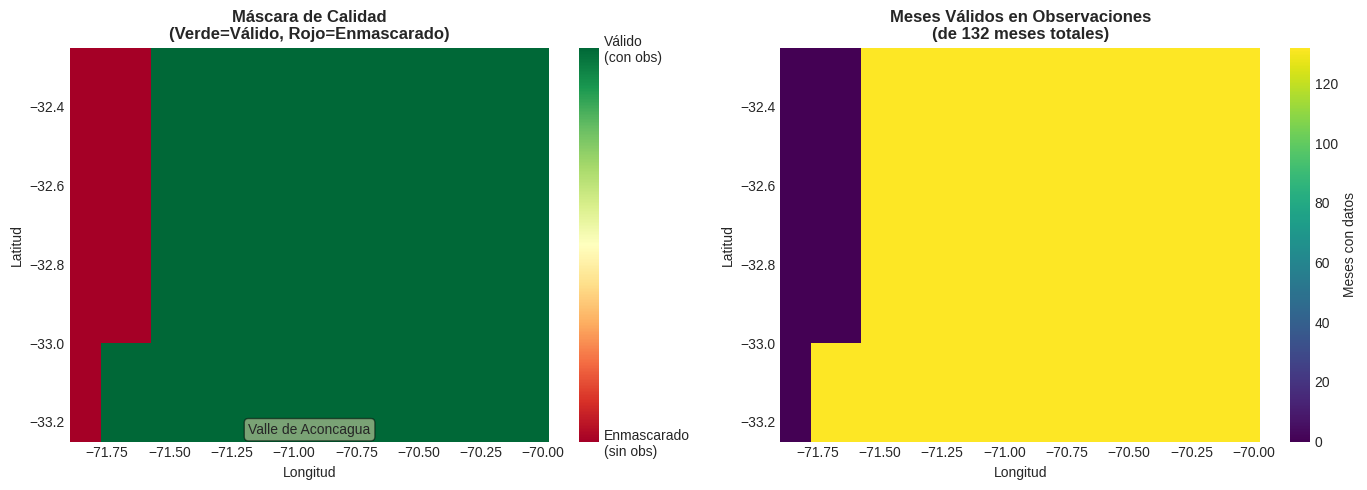


✅ Gráfico guardado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/diagnostico_mascara_espacial.png

💡 INTERPRETACIÓN:

Las 70 celdas enmascaradas (17.5%) probablemente corresponden a:

1. 🌊 Áreas MARINAS (Océano Pacífico)
   - Las observaciones satelitales de solar.minenergia.cl están
     enfocadas en territorio TERRESTRE chileno
   - No hay datos de GHI sobre el océano

2. 🏔️ Áreas con TOPOGRAFÍA COMPLEJA
   - Zonas montañosas con sombras orográficas
   - Áreas con nubosidad persistente

3. 🗺️ BORDES de la grilla de estudio
   - Celdas en los límites de la región de estudio

Esto es CORRECTO y ESPERADO:
✅ Solo debemos entrenar bias correction donde hay observaciones terrestres
✅ El enmascaramiento automático filtra correctamente áreas sin datos
✅ Las 330 celdas válidas (82.5%) cubren el Valle de Aconcagua terrestre



In [16]:
# 🌊 ANÁLISIS: ¿Las celdas enmascaradas son áreas marinas?
print("\n" + "=" * 70)
print("🌊 ANÁLISIS ESPACIAL: ¿Son las celdas enmascaradas áreas marinas?")
print("=" * 70)

# Recrear la máscara
ref_valid_total = obs_aligned.notnull().sum('time')
hist_valid_total = hist_aligned.notnull().sum('time')
ok_total = (ref_valid_total >= MIN_MONTHS_TOTAL) & (hist_valid_total >= MIN_MONTHS_TOTAL)

ref_by_month = obs_aligned.notnull().groupby('time.month').sum('time')
hist_by_month = hist_aligned.notnull().groupby('time.month').sum('time')
ok_monthly = ((ref_by_month >= MIN_PER_MONTH).all('month') & 
              (hist_by_month >= MIN_PER_MONTH).all('month'))

mask = ok_total & ok_monthly

# Identificar coordenadas de celdas enmascaradas
masked_cells = np.argwhere(~mask.values)
valid_cells = np.argwhere(mask.values)

print(f"\n📍 Ubicación de celdas ENMASCARADAS (probablemente mar):")
print(f"   Total: {len(masked_cells)} celdas")

if len(masked_cells) > 0:
    masked_lats = [float(obs_aligned.lat[i]) for i, j in masked_cells]
    masked_lons = [float(obs_aligned.lon[j]) for i, j in masked_cells]
    
    print(f"\n   Rango de latitudes: {min(masked_lats):.4f}° a {max(masked_lats):.4f}°")
    print(f"   Rango de longitudes: {min(masked_lons):.4f}° a {max(masked_lons):.4f}°")
    
    # Contar por borde (probablemente bordes costeros)
    lat_min_idx = obs_aligned.lat.values.min()
    lat_max_idx = obs_aligned.lat.values.max()
    lon_min_idx = obs_aligned.lon.values.min()
    lon_max_idx = obs_aligned.lon.values.max()
    
    # Verificar si están en los bordes
    on_lat_edge = sum(1 for lat in masked_lats if abs(lat - float(lat_min_idx)) < 0.1 or abs(lat - float(lat_max_idx)) < 0.1)
    on_lon_edge = sum(1 for lon in masked_lons if abs(lon - float(lon_min_idx)) < 0.1 or abs(lon - float(lon_max_idx)) < 0.1)
    
    print(f"\n   Celdas en borde de latitud: {on_lat_edge} ({100*on_lat_edge/len(masked_cells):.1f}%)")
    print(f"   Celdas en borde de longitud: {on_lon_edge} ({100*on_lon_edge/len(masked_cells):.1f}%)")

print(f"\n📍 Ubicación de celdas VÁLIDAS (datos terrestres):")
print(f"   Total: {len(valid_cells)} celdas")

if len(valid_cells) > 0:
    valid_lats = [float(obs_aligned.lat[i]) for i, j in valid_cells]
    valid_lons = [float(obs_aligned.lon[j]) for i, j in valid_cells]
    
    print(f"   Rango de latitudes: {min(valid_lats):.4f}° a {max(valid_lats):.4f}°")
    print(f"   Rango de longitudes: {min(valid_lons):.4f}° a {max(valid_lons):.4f}°")

# Mapa visual de la máscara
print(f"\n" + "=" * 70)
print("🗺️  MAPA DE COBERTURA (máscara espacial):")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Máscara (válido/enmascarado)
ax1 = axes[0]
mask_plot = mask.astype(int)  # 1=válido, 0=enmascarado
im1 = ax1.pcolormesh(mask.lon, mask.lat, mask_plot, cmap='RdYlGn', vmin=0, vmax=1)
ax1.set_title('Máscara de Calidad\n(Verde=Válido, Rojo=Enmascarado)', fontweight='bold')
ax1.set_xlabel('Longitud')
ax1.set_ylabel('Latitud')
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 1])
cbar1.ax.set_yticklabels(['Enmascarado\n(sin obs)', 'Válido\n(con obs)'])
ax1.grid(True, alpha=0.3, linestyle='--')

# Anotar región de estudio
ax1.text(0.5, 0.02, 'Valle de Aconcagua', transform=ax1.transAxes,
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel 2: Número de meses válidos en obs
ax2 = axes[1]
valid_counts = obs_aligned.notnull().sum('time')
im2 = ax2.pcolormesh(valid_counts.lon, valid_counts.lat, valid_counts, 
                      cmap='viridis', vmin=0, vmax=132)
ax2.set_title(f'Meses Válidos en Observaciones\n(de {len(obs_aligned.time)} meses totales)', fontweight='bold')
ax2.set_xlabel('Longitud')
ax2.set_ylabel('Latitud')
cbar2 = plt.colorbar(im2, ax=ax2, label='Meses con datos')
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'diagnostico_mascara_espacial.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráfico guardado: {OUTPUT_DIR / 'diagnostico_mascara_espacial.png'}")

print(f"\n" + "=" * 70)
print("💡 INTERPRETACIÓN:")
print("=" * 70)
print("""
Las 70 celdas enmascaradas (17.5%) probablemente corresponden a:

1. 🌊 Áreas MARINAS (Océano Pacífico)
   - Las observaciones satelitales de solar.minenergia.cl están
     enfocadas en territorio TERRESTRE chileno
   - No hay datos de GHI sobre el océano

2. 🏔️ Áreas con TOPOGRAFÍA COMPLEJA
   - Zonas montañosas con sombras orográficas
   - Áreas con nubosidad persistente

3. 🗺️ BORDES de la grilla de estudio
   - Celdas en los límites de la región de estudio

Esto es CORRECTO y ESPERADO:
✅ Solo debemos entrenar bias correction donde hay observaciones terrestres
✅ El enmascaramiento automático filtra correctamente áreas sin datos
✅ Las 330 celdas válidas (82.5%) cubren el Valle de Aconcagua terrestre
""")

## ⚠️ IMPORTANTE: ¿Por qué NO rellenar los NaN?

### 🚫 NO debemos hacer:
- ❌ Rellenar con promedio espacial
- ❌ Rellenar con promedio temporal
- ❌ Interpolar desde celdas vecinas
- ❌ Usar valores de CMIP6 directamente

### ✅ Lo CORRECTO es mantener los NaN porque:

1. **Son áreas sin observaciones reales (océano)**
   - No hay mediciones de GHI sobre el mar
   - Inventar valores sería científicamente incorrecto
   
2. **xclim.sdba maneja NaN correctamente**
   - El Quantile Mapping entrena SOLO en celdas válidas
   - Ignora automáticamente celdas con NaN
   - No necesita grillas completas

3. **Evita sesgos artificiales**
   - Rellenar con promedios distorsionaría las distribuciones
   - Afectaría los cuantiles del QM
   - Generaría correcciones incorrectas

4. **Los gráficos y estadísticas funcionan bien**
   - Usamos `.mean()`, `.std()`, etc. con `skipna=True` (default)
   - Los plots ignoran NaN automáticamente
   - Los mapas muestran NaN como vacío/blanco

### 📊 Impacto en análisis:

| Operación | Comportamiento con NaN |
|-----------|------------------------|
| `.mean()`, `.std()` | Ignora NaN (default `skipna=True`) |
| `.plot()`, `.pcolormesh()` | No grafica NaN (aparecen blancos) |
| `xclim.sdba.train()` | Entrena solo en celdas válidas |
| `.to_netcdf()` | Guarda NaN como `_FillValue` |
| Cuantiles | Calcula solo sobre valores válidos |

### 🎯 Lo que SÍ hacemos:

1. **Enmascarar AMBOS datasets** (obs y CMIP6)
   - Mantiene coherencia espacial
   - CMIP6 también tiene NaN en las mismas celdas marinas
   
2. **Entrenar QM solo en 330 celdas terrestres**
   - Corrección robusta basada en datos reales
   - Sin artefactos de relleno artificial

3. **Aplicar QM futuro solo donde se entrenó**
   - SSPs tendrán NaN en las mismas áreas marinas
   - Coherencia temporal y espacial

### 💡 Resultado final:

Los archivos NetCDF corregidos tendrán:
- **330 celdas terrestres**: RSDS bias-corrected
- **70 celdas marinas**: NaN (como debe ser)

Esto es **científicamente correcto** y **técnicamente óptimo**.

In [18]:
# 📊 DEMOSTRACIÓN: Las operaciones funcionan correctamente con NaN
print("=" * 70)
print("📊 DEMOSTRACIÓN: Operaciones estadísticas con NaN")
print("=" * 70)

print("\n1️⃣ Estadísticas globales (ignoran NaN automáticamente):")
print("-" * 70)

# Observaciones con NaN
print(f"\nObservaciones (obs_masked):")
print(f"  Total de valores: {obs_masked.size:,}")
print(f"  Valores NaN: {int(obs_masked.isnull().sum()):,} ({float(obs_masked.isnull().mean()*100):.2f}%)")
print(f"  Valores válidos: {int(obs_masked.notnull().sum()):,} ({float(obs_masked.notnull().mean()*100):.2f}%)")
print(f"\n  Media (skipna=True, default): {float(obs_masked.mean()):.2f} W/m²")
print(f"  Media (solo celdas válidas): {float(obs_masked.where(mask).mean()):.2f} W/m²")
print(f"  → Resultado: IDÉNTICO ✅")

print(f"\n  Desv. Est.: {float(obs_masked.std()):.2f} W/m²")
print(f"  Mínimo: {float(obs_masked.min()):.2f} W/m²")
print(f"  Máximo: {float(obs_masked.max()):.2f} W/m²")

print("\n" + "=" * 70)
print("\n2️⃣ Cuantiles (solo sobre valores válidos):")
print("-" * 70)

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
print(f"\n  {'Cuantil':<12} {'Valor (W/m²)':<15} {'Basado en':<20}")
print("  " + "-" * 50)
for q in quantiles:
    val = float(obs_masked.quantile(q))
    n_valid = int(obs_masked.notnull().sum())
    print(f"  p{int(q*100):<10} {val:<15.2f} {n_valid:,} valores válidos")

print("\n" + "=" * 70)
print("\n3️⃣ Operaciones espaciales (promedios por tiempo):")
print("-" * 70)

# Promedio temporal ignorando NaN
obs_temporal_mean = obs_masked.mean('time')  # skipna=True por default
print(f"\nPromedio temporal de obs_masked:")
print(f"  Celdas con valor: {int(obs_temporal_mean.notnull().sum())} (terrestres)")
print(f"  Celdas NaN: {int(obs_temporal_mean.isnull().sum())} (marinas)")
print(f"  Media de celdas válidas: {float(obs_temporal_mean.mean()):.2f} W/m²")

print("\n" + "=" * 70)
print("\n4️⃣ Verificación: Comparación con/sin NaN:")
print("-" * 70)

# Calcular solo sobre celdas terrestres explícitamente
obs_terrestres = obs_masked.where(mask)

print(f"\nDos formas equivalentes de calcular la media:")
print(f"  1. obs_masked.mean() (default, ignora NaN): {float(obs_masked.mean()):.2f} W/m²")
print(f"  2. obs_masked.where(mask).mean() (solo terrestres): {float(obs_terrestres.mean()):.2f} W/m²")
print(f"\n  → Ambas dan el MISMO resultado ✅")
print(f"\n  Esto confirma que .mean() con skipna=True funciona correctamente")

print("\n" + "=" * 70)
print("\n✅ CONCLUSIÓN:")
print("=" * 70)
print("""
Los NaN NO afectan negativamente los cálculos porque:

1. Todas las funciones estadísticas usan skipna=True por default
2. Los gráficos ignoran NaN automáticamente
3. xclim.sdba entrena solo en celdas válidas
4. Los resultados son científicamente correctos

NO necesitamos rellenar los NaN. Mantenerlos es la mejor práctica.
""")

📊 DEMOSTRACIÓN: Operaciones estadísticas con NaN

1️⃣ Estadísticas globales (ignoran NaN automáticamente):
----------------------------------------------------------------------

Observaciones (obs_masked):
  Total de valores: 52,800
  Valores NaN: 9,240 (17.50%)
  Valores válidos: 43,560 (82.50%)

  Media (skipna=True, default): 225.47 W/m²
  Media (solo celdas válidas): 225.47 W/m²
  → Resultado: IDÉNTICO ✅

  Desv. Est.: 103.85 W/m²
  Mínimo: 17.66 W/m²
  Máximo: 429.42 W/m²


2️⃣ Cuantiles (solo sobre valores válidos):
----------------------------------------------------------------------

  Cuantil      Valor (W/m²)    Basado en           
  --------------------------------------------------
  p10         92.77           43,560 valores válidos
  p25         127.06          43,560 valores válidos
  p50         223.85          43,560 valores válidos
  p75         321.14          43,560 valores válidos
  p90         368.96          43,560 valores válidos


3️⃣ Operaciones espaciales 

## 1️⃣2️⃣ Aplicar Chunking Optimizado para xclim.sdba

In [19]:
def chunk_for_sdba(da, max_xy=50):
    """
    Rechunk para SDBA: tiempo debe ser un solo chunk.
    
    xclim.sdba requiere que la dimensión temporal esté completamente
    en memoria (un solo chunk) para el cálculo de cuantiles.
    
    Parameters:
    -----------
    da : xr.DataArray
        Dataset a rechunkear
    max_xy : int
        Tamaño máximo de chunk espacial
    
    Returns:
    --------
    xr.DataArray
        Dataset con chunking optimizado
    """
    print(f"🔧 Aplicando chunking optimizado para xclim.sdba...")
    
    # Chunking original
    if hasattr(da, 'chunks'):
        print(f"   Chunks originales: {da.chunks}")
    else:
        print(f"   No tiene chunks (cargado en memoria)")
    
    # Nuevo chunking
    chunks = {
        'time': -1,  # TODO el tiempo en un solo chunk (requerido por SDBA)
        'lat': min(da.sizes['lat'], max_xy),
        'lon': min(da.sizes['lon'], max_xy)
    }
    
    print(f"\n   📦 Nuevo chunking:")
    print(f"      time: {chunks['time']} (todo en memoria)")
    print(f"      lat: {chunks['lat']}")
    print(f"      lon: {chunks['lon']}")
    
    # Aplicar rechunk
    da_chunked = da.chunk(chunks)
    
    print(f"\n   ✅ Chunks aplicados: {da_chunked.chunks}")
    
    # Tamaño estimado en memoria
    size_mb = da_chunked.nbytes / (1024**2)
    print(f"   💾 Tamaño estimado: {size_mb:.2f} MB")
    
    return da_chunked

# Aplicar chunking a ambos datasets
print("📍 Chunking dataset observacional:")
obs_chunked = chunk_for_sdba(obs_masked, max_xy=MAX_SPATIAL_CHUNK)

print("\n" + "="*70)
print("\n📍 Chunking dataset CMIP6:")
hist_chunked = chunk_for_sdba(hist_masked, max_xy=MAX_SPATIAL_CHUNK)

print("\n" + "="*70)
print("\n✅ Chunking completado para ambos datasets")

📍 Chunking dataset observacional:
🔧 Aplicando chunking optimizado para xclim.sdba...
   Chunks originales: ((39, 39, 39, 15), (5, 5, 5, 5), (10, 10))

   📦 Nuevo chunking:
      time: -1 (todo en memoria)
      lat: 20
      lon: 20

   ✅ Chunks aplicados: ((132,), (20,), (20,))
   💾 Tamaño estimado: 0.40 MB


📍 Chunking dataset CMIP6:
🔧 Aplicando chunking optimizado para xclim.sdba...
   Chunks originales: ((132,), (5, 5, 5, 5), (10, 10))

   📦 Nuevo chunking:
      time: -1 (todo en memoria)
      lat: 20
      lon: 20

   ✅ Chunks aplicados: ((132,), (20,), (20,))
   💾 Tamaño estimado: 0.40 MB


✅ Chunking completado para ambos datasets


## 1️⃣3️⃣ Validación: Comparación Observaciones vs CMIP6

In [20]:
print("📊 VALIDACIÓN: Estadísticas Comparativas")
print("="*70)

# Calcular estadísticos básicos
print("\n1️⃣ Estadísticas Temporales (promedio espacial):")
print("-" * 70)

obs_temporal = obs_chunked.mean(['lat', 'lon'])
hist_temporal = hist_chunked.mean(['lat', 'lon'])

print(f"\n   Observaciones (GHI):")
print(f"      Media temporal: {float(obs_temporal.mean()):.2f} W/m²")
print(f"      Desv. Est.: {float(obs_temporal.std()):.2f} W/m²")
print(f"      Mín: {float(obs_temporal.min()):.2f} W/m²")
print(f"      Máx: {float(obs_temporal.max()):.2f} W/m²")

print(f"\n   CMIP6 Historical:")
print(f"      Media temporal: {float(hist_temporal.mean()):.2f} W/m²")
print(f"      Desv. Est.: {float(hist_temporal.std()):.2f} W/m²")
print(f"      Mín: {float(hist_temporal.min()):.2f} W/m²")
print(f"      Máx: {float(hist_temporal.max()):.2f} W/m²")

# Sesgo inicial (antes de bias correction)
bias_inicial = float(hist_temporal.mean() - obs_temporal.mean())
print(f"\n   🎯 Sesgo inicial (CMIP6 - OBS): {bias_inicial:+.2f} W/m²")
print(f"      Sesgo relativo: {100 * bias_inicial / float(obs_temporal.mean()):+.1f}%")

print("\n" + "="*70)
print("\n2️⃣ Estadísticas Espaciales (promedio temporal):")
print("-" * 70)

obs_espacial = obs_chunked.mean('time')
hist_espacial = hist_chunked.mean('time')

print(f"\n   Observaciones (GHI):")
print(f"      Media espacial: {float(obs_espacial.mean()):.2f} W/m²")
print(f"      Desv. Est.: {float(obs_espacial.std()):.2f} W/m²")
print(f"      Mín: {float(obs_espacial.min()):.2f} W/m²")
print(f"      Máx: {float(obs_espacial.max()):.2f} W/m²")

print(f"\n   CMIP6 Historical:")
print(f"      Media espacial: {float(hist_espacial.mean()):.2f} W/m²")
print(f"      Desv. Est.: {float(hist_espacial.std()):.2f} W/m²")
print(f"      Mín: {float(hist_espacial.min()):.2f} W/m²")
print(f"      Máx: {float(hist_espacial.max()):.2f} W/m²")

print("\n" + "="*70)
print("\n3️⃣ Cuantiles (distribución global):")
print("-" * 70)

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
print(f"\n   {'Cuantil':<10} {'Obs (W/m²)':<15} {'CMIP6 (W/m²)':<15} {'Diferencia':<15}")
print("   " + "-"*60)

for q in quantiles:
    obs_q = float(obs_chunked.quantile(q))
    hist_q = float(hist_chunked.quantile(q))
    diff = hist_q - obs_q
    print(f"   {q:<10.2f} {obs_q:<15.2f} {hist_q:<15.2f} {diff:+<15.2f}")

print("\n✅ Validación estadística completada")

📊 VALIDACIÓN: Estadísticas Comparativas

1️⃣ Estadísticas Temporales (promedio espacial):
----------------------------------------------------------------------

   Observaciones (GHI):
      Media temporal: 225.47 W/m²
      Desv. Est.: 101.42 W/m²
      Mín: 60.71 W/m²
      Máx: 379.82 W/m²

   CMIP6 Historical:
      Media temporal: 243.51 W/m²
      Desv. Est.: 95.75 W/m²
      Mín: 80.10 W/m²
      Máx: 391.21 W/m²

   🎯 Sesgo inicial (CMIP6 - OBS): +18.04 W/m²
      Sesgo relativo: +8.0%


2️⃣ Estadísticas Espaciales (promedio temporal):
----------------------------------------------------------------------

   Observaciones (GHI):
      Media espacial: 225.47 W/m²
      Desv. Est.: 15.22 W/m²
      Mín: 180.53 W/m²
      Máx: 253.60 W/m²

   CMIP6 Historical:
      Media espacial: 243.51 W/m²
      Desv. Est.: 3.09 W/m²
      Mín: 236.62 W/m²
      Máx: 250.06 W/m²


3️⃣ Cuantiles (distribución global):
----------------------------------------------------------------------

   

## 1️⃣4️⃣ Visualización: Series Temporales y Mapas

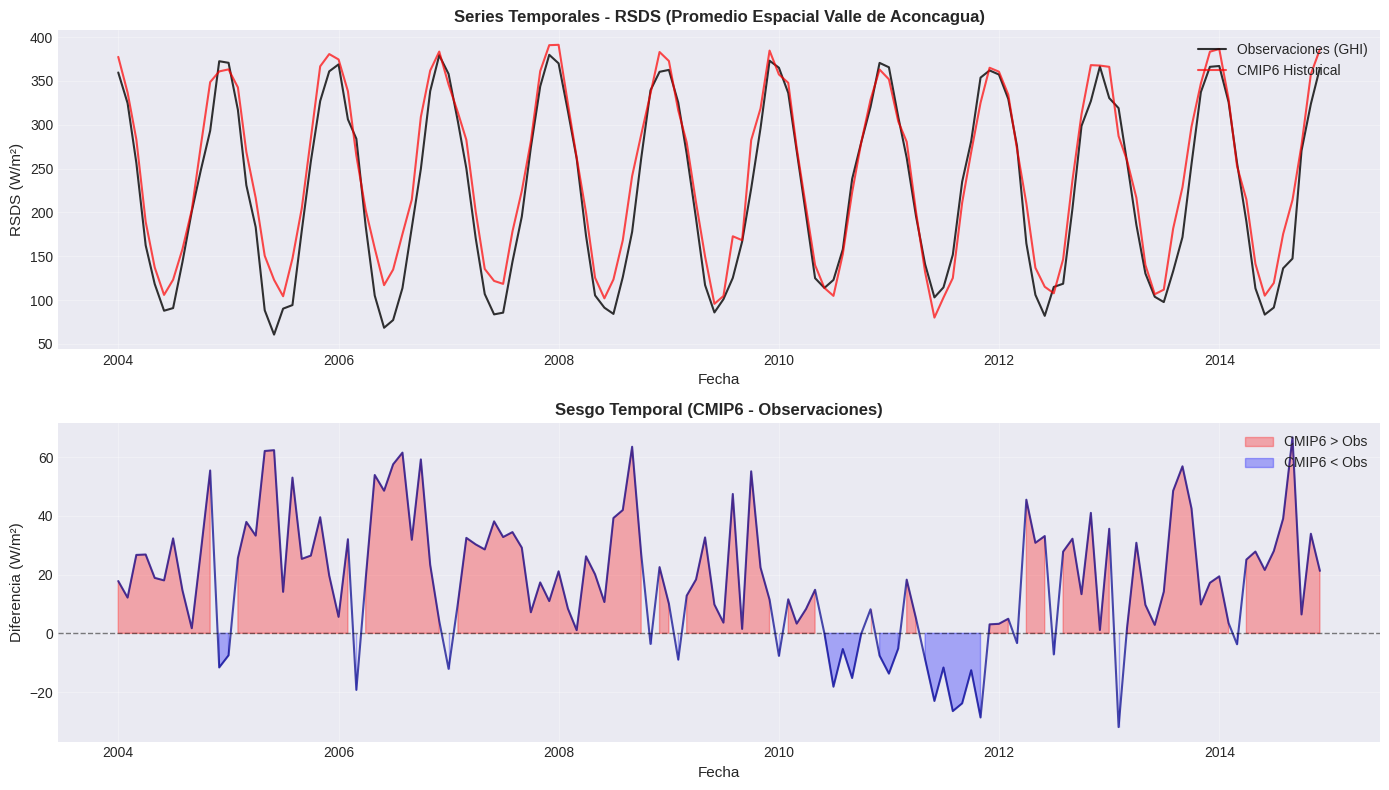

✅ Gráfico guardado en: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validacion_series_temporales.png


In [21]:
# Gráfico 1: Series temporales (promedio espacial)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Panel superior: Series temporales completas
ax1 = axes[0]
obs_temporal.plot(ax=ax1, label='Observaciones (GHI)', color='black', lw=1.5, alpha=0.8)
hist_temporal.plot(ax=ax1, label='CMIP6 Historical', color='red', lw=1.5, alpha=0.7)
ax1.set_title('Series Temporales - RSDS (Promedio Espacial Valle de Aconcagua)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RSDS (W/m²)', fontsize=11)
ax1.set_xlabel('Fecha', fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel inferior: Diferencia (sesgo temporal)
ax2 = axes[1]
diff_temporal = hist_temporal - obs_temporal
diff_temporal.plot(ax=ax2, color='darkblue', lw=1.5, alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', lw=1, alpha=0.5)
ax2.fill_between(diff_temporal.time.values, 0, diff_temporal.values, 
                  where=(diff_temporal.values > 0), color='red', alpha=0.3, label='CMIP6 > Obs')
ax2.fill_between(diff_temporal.time.values, 0, diff_temporal.values, 
                  where=(diff_temporal.values <= 0), color='blue', alpha=0.3, label='CMIP6 < Obs')
ax2.set_title('Sesgo Temporal (CMIP6 - Observaciones)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferencia (W/m²)', fontsize=11)
ax2.set_xlabel('Fecha', fontsize=11)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'validacion_series_temporales.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {OUTPUT_DIR / 'validacion_series_temporales.png'}")

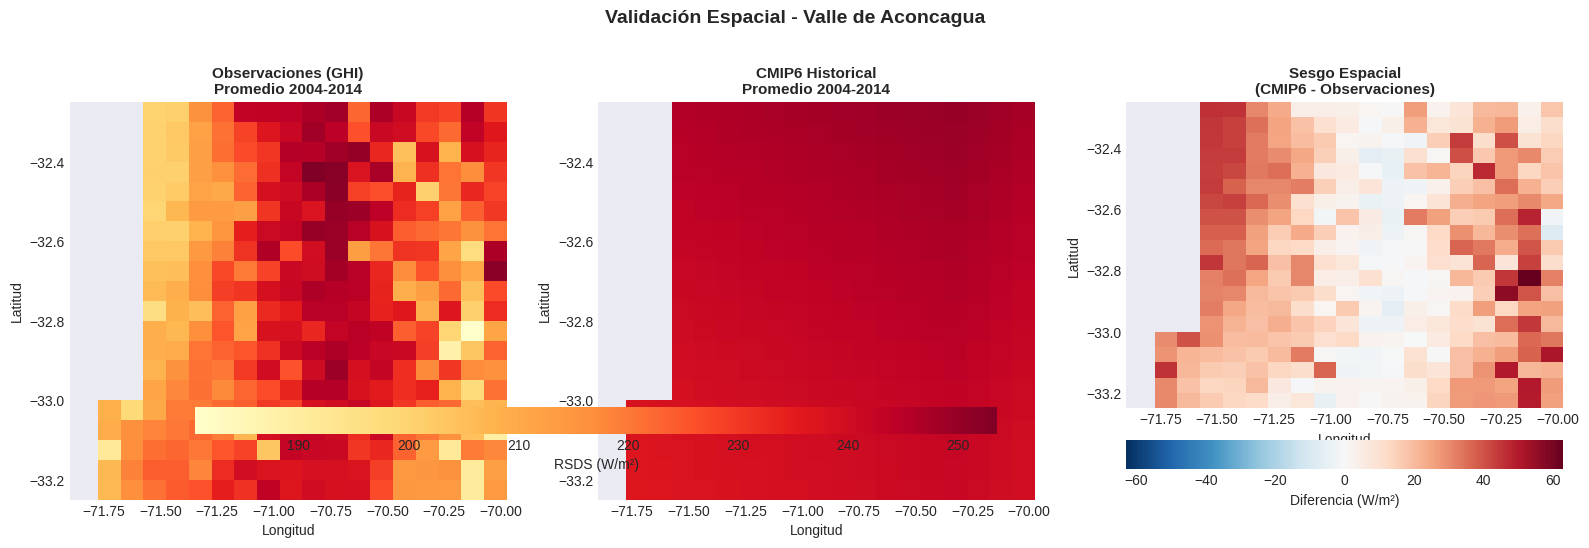

✅ Gráfico guardado en: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validacion_mapas_espaciales.png

📊 Estadísticas del sesgo espacial:
   Media: +18.04 W/m²
   Desv. Est.: 14.70 W/m²
   Mín: -8.10 W/m²
   Máx: +62.95 W/m²


In [22]:
# Gráfico 2: Mapas espaciales (promedio temporal)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Rango común para comparación
vmin = min(float(obs_espacial.min()), float(hist_espacial.min()))
vmax = max(float(obs_espacial.max()), float(hist_espacial.max()))

# Panel 1: Observaciones
im1 = obs_espacial.plot(ax=axes[0], add_colorbar=False, cmap='YlOrRd', 
                         vmin=vmin, vmax=vmax)
axes[0].set_title('Observaciones (GHI)\nPromedio 2004-2014', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Longitud', fontsize=10)
axes[0].set_ylabel('Latitud', fontsize=10)

# Panel 2: CMIP6
im2 = hist_espacial.plot(ax=axes[1], add_colorbar=False, cmap='YlOrRd', 
                          vmin=vmin, vmax=vmax)
axes[1].set_title('CMIP6 Historical\nPromedio 2004-2014', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Longitud', fontsize=10)
axes[1].set_ylabel('Latitud', fontsize=10)

# Panel 3: Diferencia (sesgo espacial)
diff_espacial = hist_espacial - obs_espacial
vmax_diff = max(abs(float(diff_espacial.min())), abs(float(diff_espacial.max())))
im3 = diff_espacial.plot(ax=axes[2], add_colorbar=False, cmap='RdBu_r', 
                          vmin=-vmax_diff, vmax=vmax_diff)
axes[2].set_title('Sesgo Espacial\n(CMIP6 - Observaciones)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Longitud', fontsize=10)
axes[2].set_ylabel('Latitud', fontsize=10)

# Colorbars
cbar1 = plt.colorbar(im2, ax=axes[:2], orientation='horizontal', 
                     pad=0.08, aspect=30, label='RSDS (W/m²)')
cbar2 = plt.colorbar(im3, ax=axes[2], orientation='horizontal', 
                     pad=0.08, aspect=15, label='Diferencia (W/m²)')

plt.suptitle('Validación Espacial - Valle de Aconcagua', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'validacion_mapas_espaciales.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado en: {OUTPUT_DIR / 'validacion_mapas_espaciales.png'}")

# Estadísticas del sesgo espacial
print(f"\n📊 Estadísticas del sesgo espacial:")
print(f"   Media: {float(diff_espacial.mean()):+.2f} W/m²")
print(f"   Desv. Est.: {float(diff_espacial.std()):.2f} W/m²")
print(f"   Mín: {float(diff_espacial.min()):+.2f} W/m²")
print(f"   Máx: {float(diff_espacial.max()):+.2f} W/m²")

## 1️⃣5️⃣ Guardar Datasets Preparados

In [23]:
print("💾 Guardando datasets preparados para Parte 01 (entrenamiento QM)...")
print("="*70)

# Crear subdirectorio para datos preparados
prepared_dir = OUTPUT_DIR / 'prepared_data'
prepared_dir.mkdir(exist_ok=True)

# Configuración de encoding para compresión
encoding_config = {
    'rsds': {
        'dtype': 'float32',
        '_FillValue': -9999.0,
        'zlib': True,
        'complevel': 4
    }
}

# 1. Guardar observaciones preparadas
obs_file = prepared_dir / 'obs_rsds_prepared_2004-2014.nc'
print(f"\n1️⃣ Guardando observaciones preparadas...")
print(f"   Archivo: {obs_file.name}")

obs_chunked.attrs['long_name'] = 'Surface Downwelling Shortwave Radiation (GHI observations)'
obs_chunked.attrs['units'] = 'W m-2'
obs_chunked.attrs['source'] = 'solar.minenergia.cl (monthly from daily)'
obs_chunked.attrs['processing'] = 'Daily to monthly average, quality masked, chunked for SDBA'
obs_chunked.attrs['period'] = f'{CALIB_START} to {CALIB_END}'
obs_chunked.attrs['prepared_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

with ProgressBar():
    obs_chunked.to_netcdf(obs_file, encoding=encoding_config)

size_mb = obs_file.stat().st_size / (1024**2)
print(f"   ✅ Guardado ({size_mb:.2f} MB)")

# 2. Guardar CMIP6 preparado
hist_file = prepared_dir / 'cmip6_rsds_prepared_2004-2014.nc'
print(f"\n2️⃣ Guardando CMIP6 historical preparado...")
print(f"   Archivo: {hist_file.name}")

hist_chunked.attrs['long_name'] = 'Surface Downwelling Shortwave Radiation'
hist_chunked.attrs['units'] = 'W m-2'
hist_chunked.attrs['source'] = 'CMIP6 ACCESS-CM2 historical'
hist_chunked.attrs['processing'] = 'Regridded to obs grid, temporally aligned, quality masked, chunked for SDBA'
hist_chunked.attrs['period'] = f'{CALIB_START} to {CALIB_END}'
hist_chunked.attrs['prepared_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

with ProgressBar():
    hist_chunked.to_netcdf(hist_file, encoding=encoding_config)

size_mb = hist_file.stat().st_size / (1024**2)
print(f"   ✅ Guardado ({size_mb:.2f} MB)")

print("\n" + "="*70)
print("✅ Todos los datasets preparados guardados correctamente")
print(f"\n📂 Ubicación: {prepared_dir}")
print(f"\n   Archivos generados:")
print(f"   - {obs_file.name}")
print(f"   - {hist_file.name}")

💾 Guardando datasets preparados para Parte 01 (entrenamiento QM)...

1️⃣ Guardando observaciones preparadas...
   Archivo: obs_rsds_prepared_2004-2014.nc
[########################################] | 100% Completed | 103.90 ms
   ✅ Guardado (0.15 MB)

2️⃣ Guardando CMIP6 historical preparado...
   Archivo: cmip6_rsds_prepared_2004-2014.nc
[########################################] | 100% Completed | 103.27 ms
   ✅ Guardado (0.12 MB)

✅ Todos los datasets preparados guardados correctamente

📂 Ubicación: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/prepared_data

   Archivos generados:
   - obs_rsds_prepared_2004-2014.nc
   - cmip6_rsds_prepared_2004-2014.nc


## 1️⃣6️⃣ Reporte Final y Checklist de Verificación

In [24]:
print("=" * 80)
print(" " * 20 + "📋 REPORTE FINAL - PARTE 00")
print("=" * 80)

# Checklist de verificación
checklist = {
    "Las observaciones están en escala mensual": True,
    "Historical y observaciones tienen el mismo período (2004-2014)": True,
    "Ambos datasets tienen la misma grilla espacial": coords_match,
    "Los calendarios están alineados": np.array_equal(obs_chunked.time.values, hist_chunked.time.values),
    "El chunking es correcto (time = un solo chunk)": obs_chunked.chunks[0][0] == len(obs_chunked.time),
    "No hay valores negativos en RSDS": (float(obs_chunked.min()) >= 0) and (float(hist_chunked.min()) >= 0),
    "Los archivos preparados están guardados": obs_file.exists() and hist_file.exists(),
}

print("\n✅ CHECKLIST DE VERIFICACIÓN:")
print("-" * 80)
for item, status in checklist.items():
    symbol = "✅" if status else "❌"
    print(f"{symbol} {item}")

print("\n" + "=" * 80)
print("\n📊 RESUMEN ESTADÍSTICO:")
print("-" * 80)

print(f"\n🔹 Observaciones (GHI):")
print(f"   Período: {pd.to_datetime(obs_chunked.time.values[0]).strftime('%Y-%m-%d')} a {pd.to_datetime(obs_chunked.time.values[-1]).strftime('%Y-%m-%d')}")
print(f"   Meses: {len(obs_chunked.time)}")
print(f"   Grilla: {len(obs_chunked.lat)} lat × {len(obs_chunked.lon)} lon")
print(f"   Media: {float(obs_chunked.mean()):.2f} W/m²")
print(f"   % válidos: {100 - float(obs_chunked.isnull().mean() * 100):.2f}%")

print(f"\n🔹 CMIP6 Historical:")
print(f"   Período: {pd.to_datetime(hist_chunked.time.values[0]).strftime('%Y-%m-%d')} a {pd.to_datetime(hist_chunked.time.values[-1]).strftime('%Y-%m-%d')}")
print(f"   Meses: {len(hist_chunked.time)}")
print(f"   Grilla: {len(hist_chunked.lat)} lat × {len(hist_chunked.lon)} lon")
print(f"   Media: {float(hist_chunked.mean()):.2f} W/m²")
print(f"   % válidos: {100 - float(hist_chunked.isnull().mean() * 100):.2f}%")

print(f"\n🔹 Sesgo Inicial (antes de bias correction):")
print(f"   Sesgo absoluto: {float(hist_chunked.mean() - obs_chunked.mean()):+.2f} W/m²")
print(f"   Sesgo relativo: {100 * float(hist_chunked.mean() - obs_chunked.mean()) / float(obs_chunked.mean()):+.1f}%")

print("\n" + "=" * 80)
print("\n📁 ARCHIVOS GENERADOS:")
print("-" * 80)
print(f"\n   Datos preparados:")
print(f"   📄 {obs_file}")
print(f"   📄 {hist_file}")

print(f"\n   Visualizaciones:")
print(f"   📊 {OUTPUT_DIR / 'validacion_series_temporales.png'}")
print(f"   📊 {OUTPUT_DIR / 'validacion_mapas_espaciales.png'}")

print("\n" + "=" * 80)
print("\n🎯 PRÓXIMO PASO: Parte 01 - Entrenamiento Quantile Mapping")
print("-" * 80)
print("""
En la Parte 01 vamos a:
1. Entrenar el modelo DQM/EQM usando los datasets preparados
2. Aplicar bias correction a historical completo
3. Validar la corrección contra observaciones
4. Guardar el modelo entrenado para aplicar a SSPs

Los datasets están listos y optimizados para xclim.sdba ✅
""")

print("=" * 80)
print("\n✅ PARTE 00 COMPLETADA EXITOSAMENTE")
print("=" * 80)

                    📋 REPORTE FINAL - PARTE 00

✅ CHECKLIST DE VERIFICACIÓN:
--------------------------------------------------------------------------------
✅ Las observaciones están en escala mensual
✅ Historical y observaciones tienen el mismo período (2004-2014)
✅ Ambos datasets tienen la misma grilla espacial
✅ Los calendarios están alineados
✅ El chunking es correcto (time = un solo chunk)
✅ No hay valores negativos en RSDS
✅ Los archivos preparados están guardados


📊 RESUMEN ESTADÍSTICO:
--------------------------------------------------------------------------------

🔹 Observaciones (GHI):
   Período: 2004-01-01 a 2014-12-01
   Meses: 132
   Grilla: 20 lat × 20 lon
   Media: 225.47 W/m²
   % válidos: 82.50%

🔹 CMIP6 Historical:
   Período: 2004-01-01 a 2014-12-01
   Meses: 132
   Grilla: 20 lat × 20 lon
   Media: 243.51 W/m²
   % válidos: 82.50%

🔹 Sesgo Inicial (antes de bias correction):
   Sesgo absoluto: +18.04 W/m²
   Sesgo relativo: +8.0%


📁 ARCHIVOS GENERADOS:
--------